In [1]:
from datasets import load_dataset
from sae_lens import SAE
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
from sklearn.decomposition import PCA, SparsePCA
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import torch
import numpy as np

### Load Dataset

In [2]:
ds = load_dataset("mksethi/truthfulqa-gemma-features")

### Create ```n_sample x sae_dim``` obj

In [3]:
import numpy as np
import datasets

COL_IN  = "correct_sae_acts"   # shape per row: [num_tokens, d_sae]
COL_OUT = "sae_mean"           # shape per row: [d_sae]

# infer d_sae once
d_sae = len(ds["train"][0][COL_IN][0])

# declare schema for the new column, helps map function load faster
features = datasets.Features({
    **ds["train"].features,
    COL_OUT: datasets.Sequence(datasets.Value("float32")),
})

# define function that will average sae activations across tokens

def pool_batch(batch):
    # batch[COL_IN] has shape [T_i, d_sae]
    means = [np.asarray(x, dtype=np.float32).mean(axis=0) for x in batch[COL_IN]]
    return {COL_OUT: means}

# Use batched + multiprocessing on CPU (no GPU needed)
pooled = ds["train"].map(
    pool_batch,
    batched=True,
    batch_size=1024,         # tune up/down based on RAM
    num_proc=4,              # parallel workers (set to your CPU cores)
    features=features,
    desc="Pooling token->sentence means",
)

# 2D NumPy array [N, d_sae]
X = np.asarray(pooled[COL_OUT], dtype=np.float32)
print(X.shape)

(817, 16384)


### Fit a PCA Transformation

In [4]:
pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[9.5228350e-01 3.0504307e-03 1.2148781e-03 1.0575111e-03 9.3499798e-04
 7.7542831e-04 7.0463761e-04 6.5055199e-04 5.7874859e-04 5.3991680e-04]
[325.41086    18.41745    11.62292    10.844047   10.196573    9.285809
   8.851805    8.505305    8.022207    7.7484055]


#### Calculate correlation between magnitude and PC1 score

In [35]:
X_tn = pca.transform(X)
scores = X_tn[:,0]

l2 = np.linalg.norm(X, axis=1)
l1 = np.sum(np.abs(X), axis=1)
nnz = np.count_nonzero(X, axis=1)
print("corr(PC1, L2):", pearsonr(scores, l2)[0])
print("corr(PC1, L1):", pearsonr(scores, l1)[0])
print("corr(PC1, nnz):", pearsonr(scores, nnz)[0])

corr(PC1, L2): -0.9994254
corr(PC1, L1): -0.99932456
corr(PC1, nnz): 0.6429268754229761


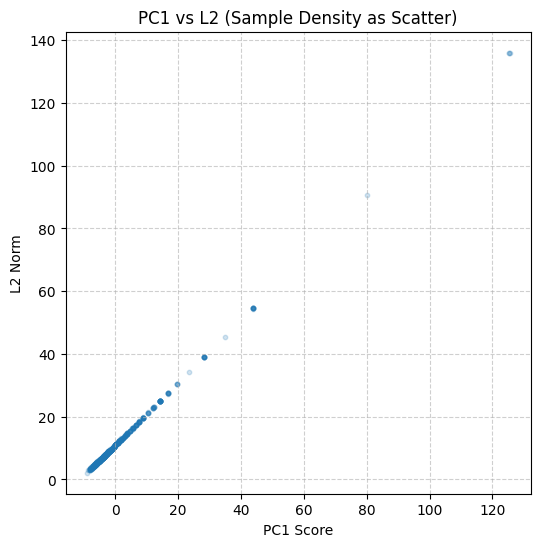

In [23]:
plt.figure(figsize=(6,6))
plt.scatter(scores, l2, s=10, alpha=0.2, c="C0")
# plt.scatter(scores, l1, s=10, alpha=0.2, c="C1")
plt.xlabel("PC1 Score")
plt.ylabel("L2 Norm")
plt.title("PC1 vs L2 (Sample Density as Scatter)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


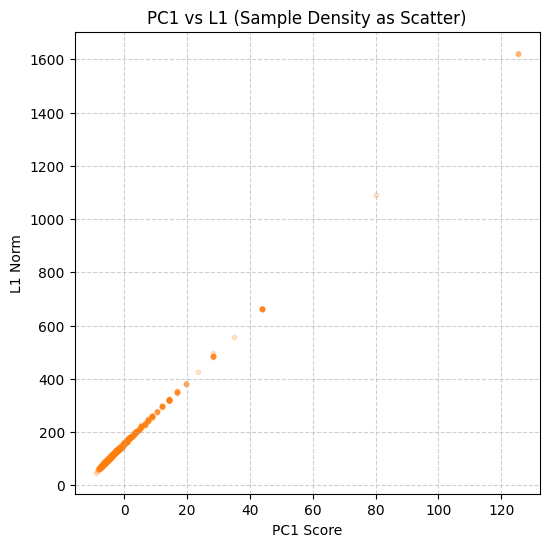

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(scores, l1, s=10, alpha=0.2, c="C1")
# plt.scatter(scores, l1, s=10, alpha=0.2, c="C1")
plt.xlabel("PC1 Score")
plt.ylabel("L1 Norm")
plt.title("PC1 vs L1 (Sample Density as Scatter)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


Above results tell us that our PCA is using magnitude as it's principal axis as opposed to some meaningful direction

### Normalized Feature Vector and L-norm Correlations

In [32]:
eps = 1e-08
row_norms = np.linalg.norm(X, axis=1, keepdims=True)

X_norm = X / (row_norms + eps)

pca = PCA(n_components=10, svd_solver='randomized', random_state=0)
scores = pca.fit_transform(X_norm)

pc1 = scores[:,0]
l2 = np.linalg.norm(X_norm, axis=1)
l1 = np.sum(np.abs(X_norm), axis=1)
nnz = np.count_nonzero(X_norm, axis=1)

print("corr(PC1, L2):", pearsonr(pc1, l2)[0])   # should be ~0 now
print("corr(PC1, L1):", pearsonr(pc1, l1)[0])   # should drop a lot...
print("corr(PC1, nnz):", pearsonr(pc1, nnz)[0]) # also should drop
print("PC1 var ratio:", pca.explained_variance_ratio_[0])

corr(PC1, L2): -0.11737361
corr(PC1, L1): 0.88824254
corr(PC1, nnz): 0.8819670774995092
PC1 var ratio: 0.052242544


/tmp/ipykernel_45389/803882321.py:14: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  print("corr(PC1, L2):", pearsonr(pc1, l2)[0])   # should be ~0 now


In [39]:
U1 = pca.components_[0:1]           
X_resid = X_norm - (X_norm @ U1.T) @ U1 #Get rid of first component
pca2 = PCA(n_components=50, svd_solver="randomized", random_state=0)
scores2 = pca2.fit_transform(X_resid)

pc1b = scores2[:, 0]
print("new PC1 var ratio:", pca2.explained_variance_ratio_[0])
print("corr(new PC1, L1):", pearsonr(pc1b, np.sum(np.abs(X_resid), axis=1))[0])

new PC1 var ratio: 0.031647064
corr(new PC1, L1): -0.30844495


# Next Steps
## some rough notes:
Corr between mag and task of model
Next step:
See if we can discriminate using uor

Run this experiment for every layer
    is this a general property or do different layers have different amounts of information
        i.e. variance is spread out across diff pca dimensions

diff hypothesis:

might be possible for gemma, 817 samples all 'occupy' space of layer 12

Fit a linear model onto our representation matrix, i.e. go from 131k to "hallu or not"